# 05__mpranalyze_compare

in this notebook, i run MPRAnalyze in 'compare' mode to get log2 foldchanges and p-values between (a) sequence orthologs and (b) cell types.

In [1]:
# # install MPRAnalyze
# if (!requireNamespace("BiocManager", quietly = TRUE))
#   install.packages("BiocManager")
# BiocManager::install("MPRAnalyze", version = "3.8")

In [2]:
# # install RCurl
# install.packages("RCurl")

In [3]:
# # install biocparallel
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("BiocParallel")

In [4]:
# load the package
library(MPRAnalyze)
library(tidyr)

In [5]:
library(BiocParallel)

## 1. load data

### first load data for library depth correction

In [6]:
dna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)

# since we only have 1 dna replicate -- add another so code doesn't crash (expects matrix)
dna_counts_depth["dna_2"] <- dna_counts_depth["dna_1"]

row.names(dna_counts_depth) <- dna_counts_depth$element
dna_counts_depth <- dna_counts_depth[ , !(names(dna_counts_depth) %in% c("element")), drop=FALSE]
dna_counts_depth <- as.matrix(dna_counts_depth)

In [7]:
rna_counts_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_counts.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
row.names(rna_counts_depth) <- rna_counts_depth$element
rna_counts_depth <- rna_counts_depth[ , !(names(rna_counts_depth) %in% c("element")), drop=FALSE]
rna_counts_depth <- as.matrix(rna_counts_depth)

In [9]:
dna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(dna_cols_depth) <- c("id", "condition", "sample")

# add second row to dna_cols_depth
row2 <- data.frame(id="dna_2", condition="dna", sample="2")
dna_cols_depth <- rbind(dna_cols_depth, row2)
row.names(dna_cols_depth) <- dna_cols_depth$id

rna_cols_depth <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/rna_col_ann.for_depth_estimation.mpranalyze.txt", sep="\t", header=TRUE)
names(rna_cols_depth) <- c("id", "condition", "sample")
row.names(rna_cols_depth) <- rna_cols_depth$id
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<int>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


In [10]:
# make sure everything is a factor
dna_cols_depth$condition <- as.factor(dna_cols_depth$condition)
rna_cols_depth$condition <- as.factor(rna_cols_depth$condition)
rna_cols_depth$sample <- as.factor(rna_cols_depth$sample)
rna_cols_depth

,id,condition,sample
,<fct>,<fct>,<fct>
HUES64_rep1,HUES64_rep1,HUES64,1
HUES64_rep2,HUES64_rep2,HUES64,2
HUES64_rep3,HUES64_rep3,HUES64,3
mESC_rep1,mESC_rep1,mESC,1
mESC_rep2,mESC_rep2,mESC,2
mESC_rep3,mESC_rep3,mESC,3


### then data to model: first, DNA (same for all models)

In [11]:
all_comp_dna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_counts.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_counts) <- all_comp_dna_counts$comp_id
all_comp_dna_counts <- all_comp_dna_counts[ , !(names(all_comp_dna_counts) %in% c("comp_id"))]
all_comp_dna_counts <- as.matrix(all_comp_dna_counts)

In [12]:
all_comp_dna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/dna_col_ann.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_comp_dna_cols) <- all_comp_dna_cols$X
head(all_comp_dna_cols)

,X,condition,barcode,seq
,<fct>,<fct>,<int>,<fct>
samp:dna_1__barc:10___seq:human,samp:dna_1__barc:10___seq:human,dna,10,human
samp:dna_1__barc:10___seq:mouse,samp:dna_1__barc:10___seq:mouse,dna,10,mouse
samp:dna_1__barc:11___seq:human,samp:dna_1__barc:11___seq:human,dna,11,human
samp:dna_1__barc:11___seq:mouse,samp:dna_1__barc:11___seq:mouse,dna,11,mouse
samp:dna_1__barc:12___seq:human,samp:dna_1__barc:12___seq:human,dna,12,human
samp:dna_1__barc:12___seq:mouse,samp:dna_1__barc:12___seq:mouse,dna,12,mouse


In [13]:
all_comp_dna_cols$barcode <- as.factor(all_comp_dna_cols$barcode)
all_comp_dna_cols$seq <- as.factor(all_comp_dna_cols$seq)
all_comp_dna_cols$condition <- as.factor(all_comp_dna_cols$condition)
all_comp_dna_cols

,X,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>
samp:dna_1__barc:10___seq:human,samp:dna_1__barc:10___seq:human,dna,10,human
samp:dna_1__barc:10___seq:mouse,samp:dna_1__barc:10___seq:mouse,dna,10,mouse
samp:dna_1__barc:11___seq:human,samp:dna_1__barc:11___seq:human,dna,11,human
samp:dna_1__barc:11___seq:mouse,samp:dna_1__barc:11___seq:mouse,dna,11,mouse
samp:dna_1__barc:12___seq:human,samp:dna_1__barc:12___seq:human,dna,12,human
samp:dna_1__barc:12___seq:mouse,samp:dna_1__barc:12___seq:mouse,dna,12,mouse
samp:dna_1__barc:13___seq:human,samp:dna_1__barc:13___seq:human,dna,13,human
samp:dna_1__barc:13___seq:mouse,samp:dna_1__barc:13___seq:mouse,dna,13,mouse
samp:dna_1__barc:1___seq:human,samp:dna_1__barc:1___seq:human,dna,1,human


### then controls (same for all models)

In [14]:
all_comp_ctrls <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/ctrl_status.all_comp.mpranalyze.txt", sep="\t", header=TRUE)
all_comp_ctrls <- as.logical(all_comp_ctrls$ctrl_status)
head(all_comp_ctrls)

[1] FALSE FALSE FALSE FALSE FALSE FALSE

In [15]:
length(all_comp_ctrls)

[1] 5850

### then data to model: native effects

In [16]:
native_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/native_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(native_rna_counts) <- native_rna_counts$comp_id
native_rna_counts <- native_rna_counts[ , !(names(native_rna_counts) %in% c("comp_id"))]
native_rna_counts <- as.matrix(native_rna_counts)

In [17]:
native_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/native_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(native_rna_cols) <- native_rna_cols$X
head(native_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<int>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


In [19]:
# make sure everything is a factor
native_rna_cols$barcode <- as.factor(native_rna_cols$barcode)
native_rna_cols$seq <- as.factor(native_rna_cols$seq)
native_rna_cols$condition <- as.factor(native_rna_cols$condition)
head(native_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


### cis+ trans interactions

In [20]:
all_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/all_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_rna_counts) <- all_rna_counts$comp_id
all_rna_counts <- all_rna_counts[ , !(names(all_rna_counts) %in% c("comp_id"))]
all_rna_counts <- as.matrix(all_rna_counts)

In [21]:
all_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/all_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(all_rna_cols) <- all_rna_cols$X

In [22]:
# make sure everything is a factor
all_rna_cols$barcode <- as.factor(all_rna_cols$barcode)
all_rna_cols$seq <- as.factor(all_rna_cols$seq)
all_rna_cols$condition <- as.factor(all_rna_cols$condition)
head(all_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse


### human/mouse data for cis effects in each cell line

In [23]:
# for seq comparisons, load each cell line data separately
hues64_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_counts) <- hues64_rna_counts$comp_id
hues64_rna_counts <- hues64_rna_counts[ , !(names(hues64_rna_counts) %in% c("comp_id"))]
hues64_rna_counts <- as.matrix(hues64_rna_counts)

mesc_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_rna_counts.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_counts) <- mesc_rna_counts$comp_id
mesc_rna_counts <- mesc_rna_counts[ , !(names(mesc_rna_counts) %in% c("comp_id"))]
mesc_rna_counts <- as.matrix(mesc_rna_counts)

In [24]:
hues64_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/HUES64_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(hues64_rna_cols) <- hues64_rna_cols$X

mesc_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mESC_col_ann.seq_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mesc_rna_cols) <- mesc_rna_cols$X

In [25]:
# make sure everything is a factor
hues64_rna_cols$barcode <- as.factor(hues64_rna_cols$barcode)
mesc_rna_cols$barcode <- as.factor(mesc_rna_cols$barcode)

hues64_rna_cols$seq <- as.factor(hues64_rna_cols$seq)
mesc_rna_cols$seq <- as.factor(mesc_rna_cols$seq)

hues64_rna_cols$condition <- as.factor(hues64_rna_cols$condition)
mesc_rna_cols$condition <- as.factor(mesc_rna_cols$condition)

head(hues64_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse


### human/mouse data for trans effects of each sequence

In [26]:
# for cell comparisons, load each cell line data separately
human_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_rna_counts.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_counts) <- human_rna_counts$comp_id
human_rna_counts <- human_rna_counts[ , !(names(human_rna_counts) %in% c("comp_id"))]
human_rna_counts <- as.matrix(human_rna_counts)

mouse_rna_counts <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_rna_counts.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_counts) <- mouse_rna_counts$comp_id
mouse_rna_counts <- mouse_rna_counts[ , !(names(mouse_rna_counts) %in% c("comp_id"))]
mouse_rna_counts <- as.matrix(mouse_rna_counts)

In [27]:
human_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/human_col_ann.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(human_rna_cols) <- human_rna_cols$X

mouse_rna_cols <- read.table("../../../data/02__mpra/01__counts/mpranalyze_files/mouse_col_ann.cell_comp.mpranalyze.txt", sep="\t", header=TRUE)
row.names(mouse_rna_cols) <- mouse_rna_cols$X

In [28]:
# make sure everything is a factor
human_rna_cols$barcode <- as.factor(human_rna_cols$barcode)
mouse_rna_cols$barcode <- as.factor(mouse_rna_cols$barcode)

human_rna_cols$seq <- as.factor(human_rna_cols$seq)
mouse_rna_cols$seq <- as.factor(mouse_rna_cols$seq)

human_rna_cols$condition <- as.factor(human_rna_cols$condition)
mouse_rna_cols$condition <- as.factor(mouse_rna_cols$condition)

head(human_rna_cols)

,X,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


## 2. estimate library depth for sample/condition pair

since our library has many more sequences than just the TSSs we want to model, estimate the library depth based on the full seq output (or downsampled counts, in HUES64 case), then manually provide this estimation to the model

In [29]:
# create MPRA object
depth_obj <- MpraObject(dnaCounts = dna_counts_depth, rnaCounts = rna_counts_depth, 
                        dnaAnnot = dna_cols_depth, rnaAnnot = rna_cols_depth)

In [30]:
# estimate depth factors using uq -- here, a sample/condition pair == 1 library
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("sample", "condition"),  depth.estimator='uq',
                                  which.lib = "dna")
depth_obj <- estimateDepthFactors(depth_obj, lib.factor = c("id"),  
                                  depth.estimator='uq', which.lib = "rna")

In [31]:
rna_depths <- rnaDepth(depth_obj)
rna_depths

[1] 1.0000000 0.6751932 0.7720110 0.3075865 0.3853071 0.3660570

In [32]:
rna_cols_depth$depth <- rna_depths
rna_cols_depth

,id,condition,sample,depth
,<fct>,<fct>,<fct>,<dbl>
HUES64_rep1,HUES64_rep1,HUES64,1,1.0000000
HUES64_rep2,HUES64_rep2,HUES64,2,0.6751932
HUES64_rep3,HUES64_rep3,HUES64,3,0.7720110
mESC_rep1,mESC_rep1,mESC,1,0.3075865
mESC_rep2,mESC_rep2,mESC,2,0.3853071
mESC_rep3,mESC_rep3,mESC,3,0.3660570


## 3. run model to compare native effects

In [33]:
nrow(rna_cols_depth)

[1] 6

In [34]:
nrow(native_rna_cols)

[1] 78

In [35]:
head(native_rna_cols)

,X,index,condition,barcode,seq
,<fct>,<fct>,<fct>,<fct>,<fct>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human
samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,samp:HUES64_rep1__barc:13___seq:human,HUES64,13,human
samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,samp:HUES64_rep1__barc:1___seq:human,HUES64,1,human
samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,samp:HUES64_rep1__barc:2___seq:human,HUES64,2,human


In [36]:
# first need to set the dnadepths and rnadepths manually
all_comp_dna_cols$depth <- rep(1, nrow(all_comp_dna_cols))

# note 13 will change depending how many barcodes there are per element
native_rna_cols$depth <- rep(rna_depths, each=13)

In [37]:
# create MPRA object
obj <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = native_rna_counts, 
                  dnaAnnot = all_comp_dna_cols, rnaAnnot = native_rna_cols, controls = all_comp_ctrls,
                  BPPARAM = SnowParam(workers=16,type="SOCK"))

In [38]:
obj <- setDepthFactors(obj, dnaDepth = all_comp_dna_cols$depth, rnaDepth = native_rna_cols$depth)

In [39]:
obj <- analyzeComparative(obj = obj, 
                          dnaDesign = ~ barcode, 
                          rnaDesign = ~ seq, 
                          reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-100068692.176791
iter:3	log-likelihood:-100017193.672721
iter:4	log-likelihood:-99988723.2677716
iter:5	log-likelihood:-99972744.3826645
iter:6	log-likelihood:-99965712.1934506
iter:7	log-likelihood:-99965185.7072511
iter:8	log-likelihood:-99969141.5962358
Fitting model...
Fitting reduced model...
Analysis Done!


In [40]:
native_res <- testLrt(obj)
head(native_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__div_lnc__m.1__div_lnc__tile1,1.22109407,2.691460e-01,3.464256e-01,1,14,5,4,-0.30358234
h.3__div_lnc__m.2__antisense__tile1,34.82500269,3.607112e-09,3.226545e-08,1,13,5,4,2.41037408
h.4__antisense_upep__m.3__protein_coding__tile1,2.32381939,1.274069e-01,1.844420e-01,1,14,5,4,0.40062336
h.5__intergenic__m.4__intergenic_upep__tile1,12.44011926,4.202090e-04,1.219356e-03,1,14,5,4,-0.77996830
h.6__intergenic__m.4__intergenic_upep__tile1,55.28481866,1.042708e-13,2.439937e-12,1,14,5,4,-1.66649581
h.7__div_lnc__m.5__div_lnc__tile1,0.02293658,8.796221e-01,9.074156e-01,1,14,5,4,-0.03520427


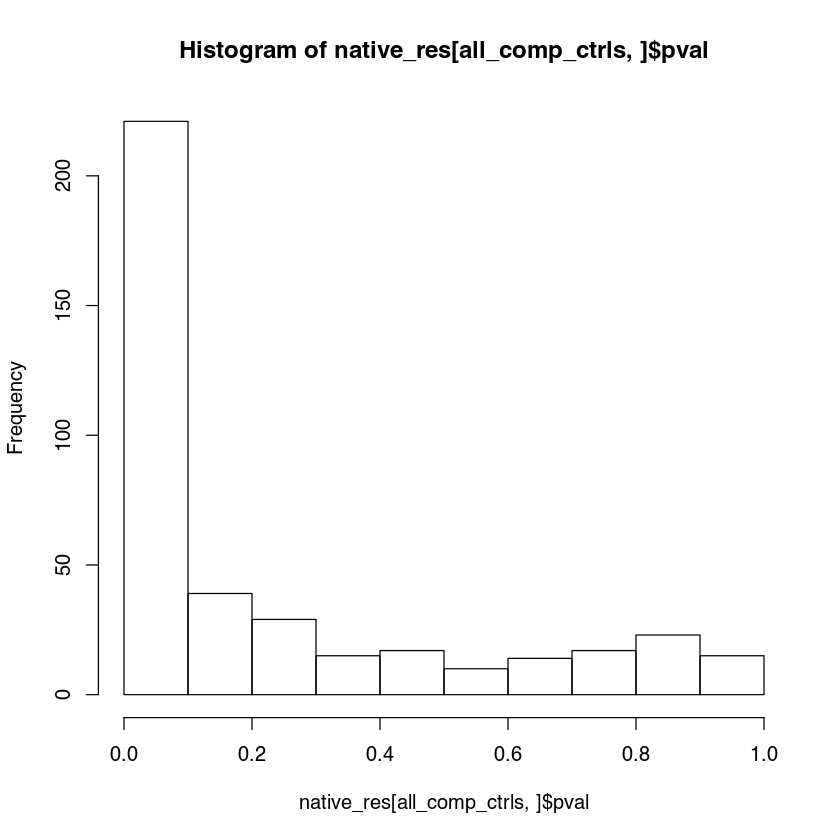

In [41]:
hist(native_res[all_comp_ctrls,]$pval)

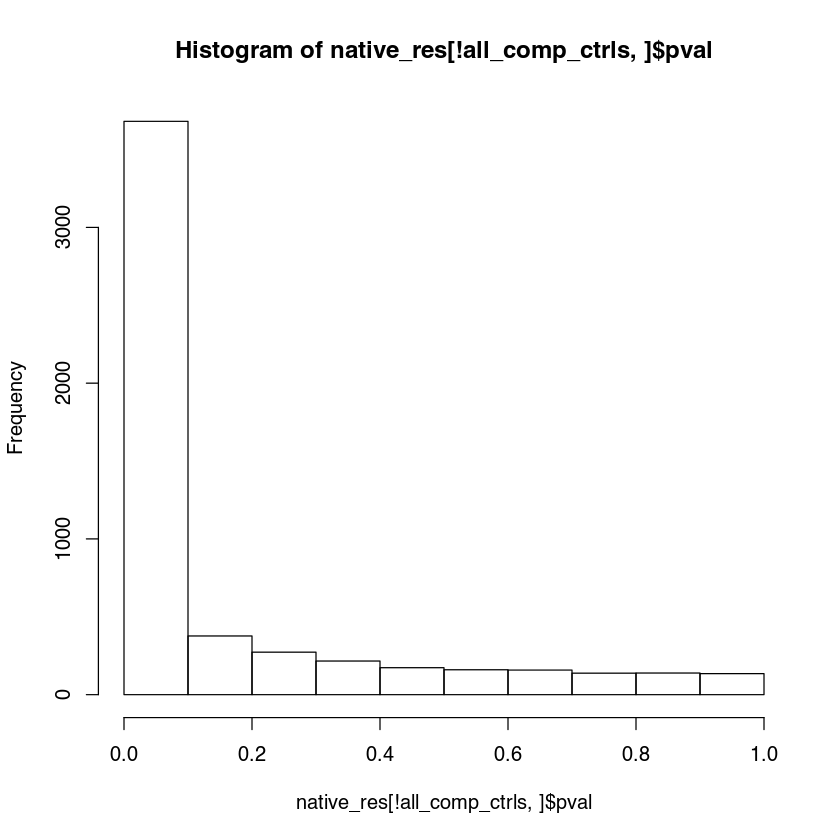

In [42]:
hist(native_res[!all_comp_ctrls,]$pval)

In [43]:
write.table(native_res, file = "../../../data/02__mpra/02__activs/native_results.txt", sep = "\t",
            quote = FALSE)

## 4. run model to compare seq / condition interactions

In [44]:
# note 13 will change depending how many barcodes there are per element
all_rna_cols$depth <- rep(rna_depths, each=26)

In [45]:
# create MPRA object
obj1 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = all_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = all_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [46]:
obj1 <- setDepthFactors(obj1, dnaDepth = all_comp_dna_cols$depth, rnaDepth = all_rna_cols$depth)

In [47]:
head(all_rna_cols)

,X,index,condition,barcode,seq,depth
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,samp:HUES64_rep1__barc:10___seq:human,HUES64,10,human,1
samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,samp:HUES64_rep1__barc:10___seq:mouse,HUES64,10,mouse,1
samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,samp:HUES64_rep1__barc:11___seq:human,HUES64,11,human,1
samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,samp:HUES64_rep1__barc:11___seq:mouse,HUES64,11,mouse,1
samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,samp:HUES64_rep1__barc:12___seq:human,HUES64,12,human,1
samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,samp:HUES64_rep1__barc:12___seq:mouse,HUES64,12,mouse,1


In [49]:
obj1 <- analyzeComparative(obj = obj1, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq + condition+ seq:condition, 
                           reducedDesign = ~ seq + condition) 

Fitting controls-based background model...
iter:2	log-likelihood:-199828013.732501
iter:3	log-likelihood:-199792974.979628
iter:4	log-likelihood:-199767588.749596
iter:5	log-likelihood:-199746694.266282
iter:6	log-likelihood:-199729980.211928
iter:7	log-likelihood:-199717030.404818
iter:8	log-likelihood:-199707345.753919
iter:9	log-likelihood:-199700420.889064
iter:10	log-likelihood:-199695931.801935
iter:11	log-likelihood:-199693412.851542
iter:12	log-likelihood:-199692538.601174
iter:13	log-likelihood:-199692937.40261
Fitting model...
Fitting reduced model...
Analysis Done!


In [50]:
int_res <- testLrt(obj1)
head(int_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__div_lnc__m.1__div_lnc__tile1,0.011534340,0.914473205,0.9887852,1,14,9,8,-0.03537962
h.3__div_lnc__m.2__antisense__tile1,0.670693160,0.412810044,0.9215623,1,13,9,8,-0.38785698
h.4__antisense_upep__m.3__protein_coding__tile1,0.365130233,0.545670749,0.9592646,1,14,9,8,-0.19285355
h.5__intergenic__m.4__intergenic_upep__tile1,6.873308490,0.008749253,0.1976183,1,14,9,8,-0.72363291
h.6__intergenic__m.4__intergenic_upep__tile1,4.025911135,0.044806411,0.4534905,1,14,9,8,-0.51176285
h.7__div_lnc__m.5__div_lnc__tile1,0.004311234,0.947648528,0.9918219,1,14,9,8,0.01717594


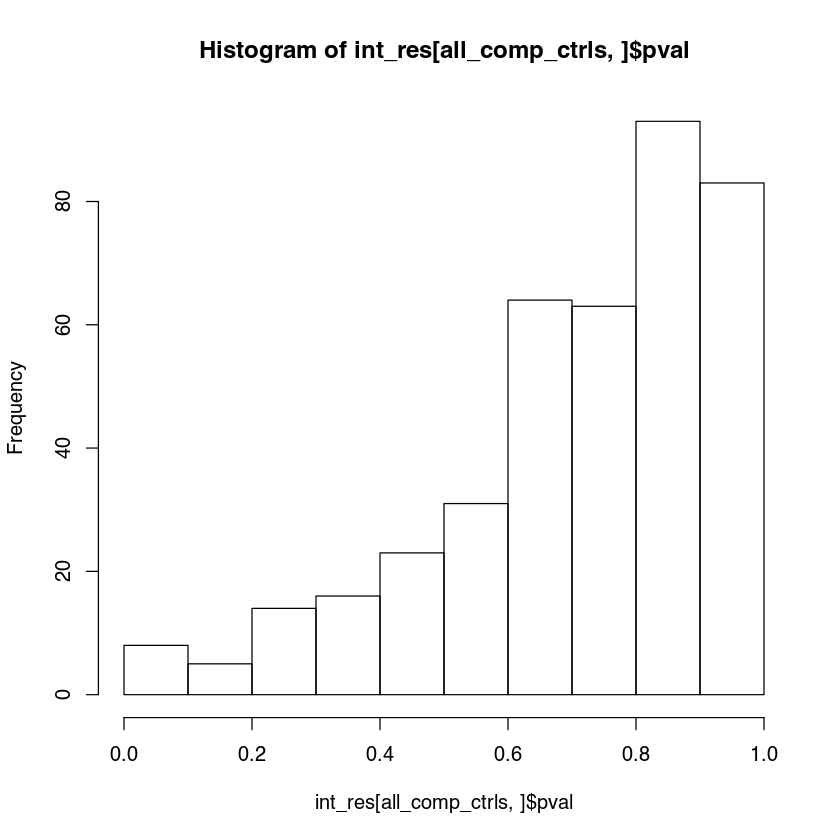

In [51]:
hist(int_res[all_comp_ctrls,]$pval)

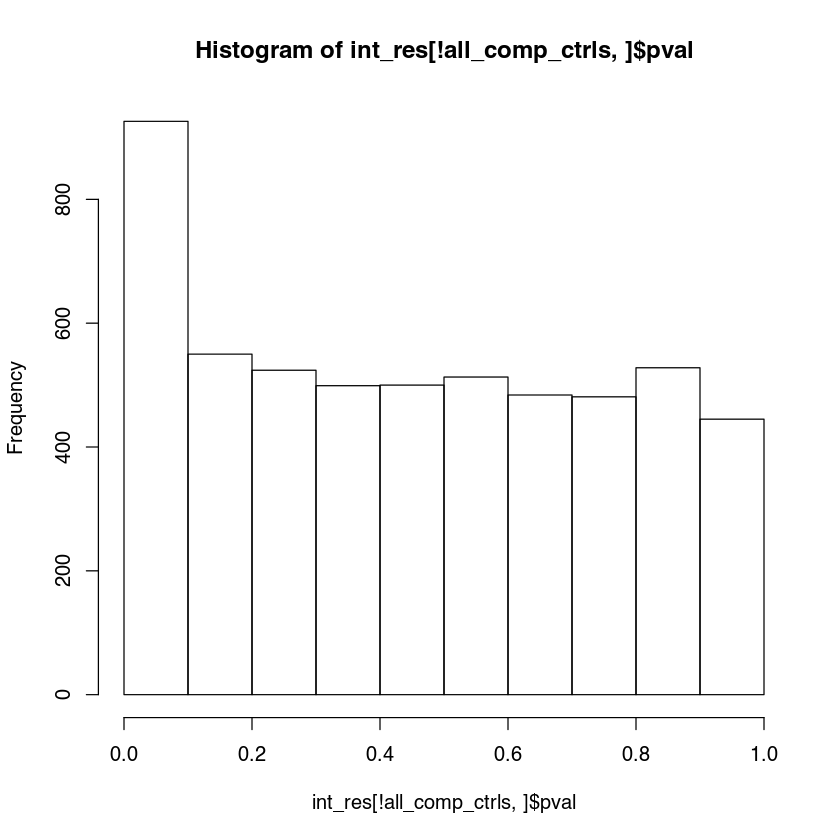

In [52]:
hist(int_res[!all_comp_ctrls,]$pval)

In [53]:
write.table(int_res, file = "../../../data/02__mpra/02__activs/cis_trans_interaction_results.txt", sep = "\t",
            quote = FALSE)

## 5. run model to compare seqs in HUES64

In [54]:
rna_cols_depth

,id,condition,sample,depth
,<fct>,<fct>,<fct>,<dbl>
HUES64_rep1,HUES64_rep1,HUES64,1,1.0000000
HUES64_rep2,HUES64_rep2,HUES64,2,0.6751932
HUES64_rep3,HUES64_rep3,HUES64,3,0.7720110
mESC_rep1,mESC_rep1,mESC,1,0.3075865
mESC_rep2,mESC_rep2,mESC,2,0.3853071
mESC_rep3,mESC_rep3,mESC,3,0.3660570


In [55]:
hues64_depths <- rna_depths[1:3]
hues64_depths

[1] 1.0000000 0.6751932 0.7720110

In [56]:
# note 13 will change depending how many barcodes there are per element
hues64_rna_cols$depth <- rep(hues64_depths, each=26)

In [57]:
# create MPRA object
obj2 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = hues64_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = hues64_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [58]:
obj2 <- setDepthFactors(obj2, dnaDepth = all_comp_dna_cols$depth, rnaDepth = hues64_rna_cols$depth)

In [59]:
obj2 <- analyzeComparative(obj = obj2, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-105569036.236941
iter:3	log-likelihood:-105513696.733376
iter:4	log-likelihood:-105475771.223064
iter:5	log-likelihood:-105452583.170337
iter:6	log-likelihood:-105441501.775885
iter:7	log-likelihood:-105439785.563277
iter:8	log-likelihood:-105444829.708296
Fitting model...
Fitting reduced model...
Analysis Done!


In [60]:
hues64_res <- testLrt(obj2)
head(hues64_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__div_lnc__m.1__div_lnc__tile1,0.07303071,7.869741e-01,8.403766e-01,1,14,5,4,-0.07048942
h.3__div_lnc__m.2__antisense__tile1,21.58215032,3.389921e-06,1.612279e-05,1,13,5,4,1.81847138
h.4__antisense_upep__m.3__protein_coding__tile1,1.36633016,2.424434e-01,3.218275e-01,1,14,5,4,0.31234289
h.5__intergenic__m.4__intergenic_upep__tile1,4.89230317,2.697668e-02,4.940938e-02,1,14,5,4,-0.55507177
h.6__intergenic__m.4__intergenic_upep__tile1,35.48438654,2.571032e-09,2.391182e-08,1,14,5,4,-1.44022788
h.7__div_lnc__m.5__div_lnc__tile1,1.08838359,2.968296e-01,3.808847e-01,1,14,5,4,-0.21369352


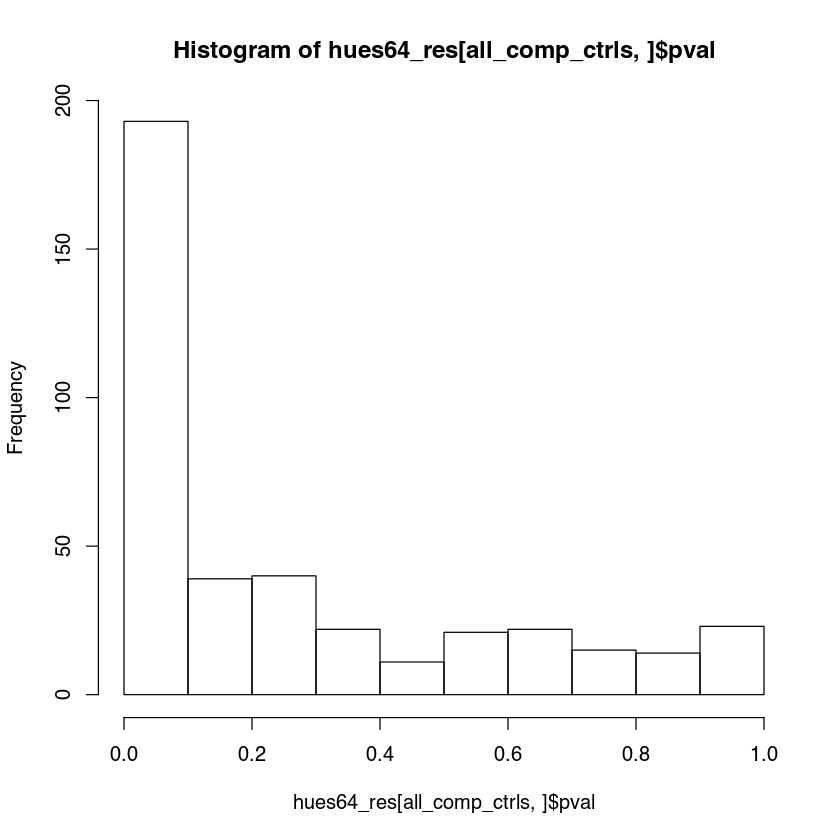

In [61]:
hist(hues64_res[all_comp_ctrls,]$pval)

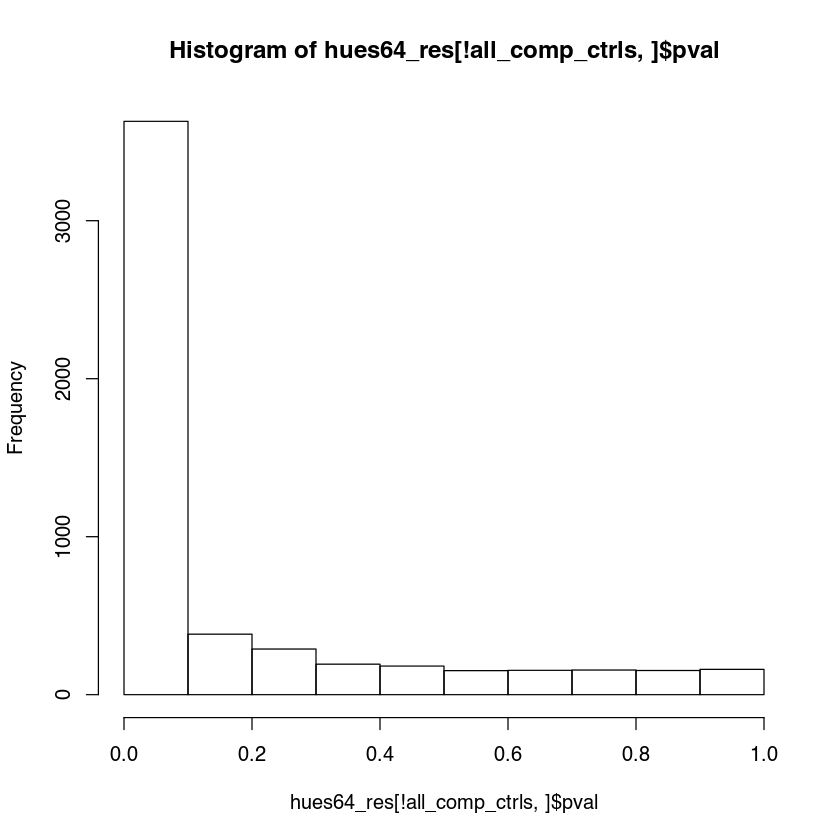

In [62]:
hist(hues64_res[!all_comp_ctrls,]$pval)

In [63]:
write.table(hues64_res, file = "../../../data/02__mpra/02__activs/HUES64_cis_results.txt", sep = "\t",
            quote = FALSE)

## 6. run model to compare seqs in mESC

In [64]:
# note 13 will change depending how many barcodes there are per element
mesc_depths <- rna_depths[4:6]
mesc_rna_cols$depth <- rep(mesc_depths, each=26)

In [65]:
# create MPRA object
obj3 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mesc_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mesc_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [66]:
obj3 <- setDepthFactors(obj3, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mesc_rna_cols$depth)

In [67]:
obj3 <- analyzeComparative(obj = obj3, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ seq, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-94381932.4844239
iter:3	log-likelihood:-94349124.8103141
iter:4	log-likelihood:-94327573.1220763
iter:5	log-likelihood:-94314556.3334398
iter:6	log-likelihood:-94307879.8350036
iter:7	log-likelihood:-94305872.6087652
iter:8	log-likelihood:-94307135.6968907
Fitting model...
Fitting reduced model...
Analysis Done!


In [68]:
mesc_res <- testLrt(obj3)
head(mesc_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__div_lnc__m.1__div_lnc__tile1,0.13379329,7.145310e-01,7.848161e-01,1,14,5,4,-0.1072892
h.3__div_lnc__m.2__antisense__tile1,10.99983275,9.112011e-04,3.033223e-03,1,13,5,4,1.8341352
h.4__antisense_upep__m.3__protein_coding__tile1,0.05705511,8.112125e-01,8.629920e-01,1,14,5,4,0.0640350
h.5__intergenic__m.4__intergenic_upep__tile1,30.78091145,2.888654e-08,3.012233e-07,1,14,5,4,-1.2158156
h.6__intergenic__m.4__intergenic_upep__tile1,66.96352079,2.765780e-16,1.903507e-14,1,14,5,4,-1.8803190
h.7__div_lnc__m.5__div_lnc__tile1,0.87488282,3.496071e-01,4.515790e-01,1,14,5,4,-0.2225260


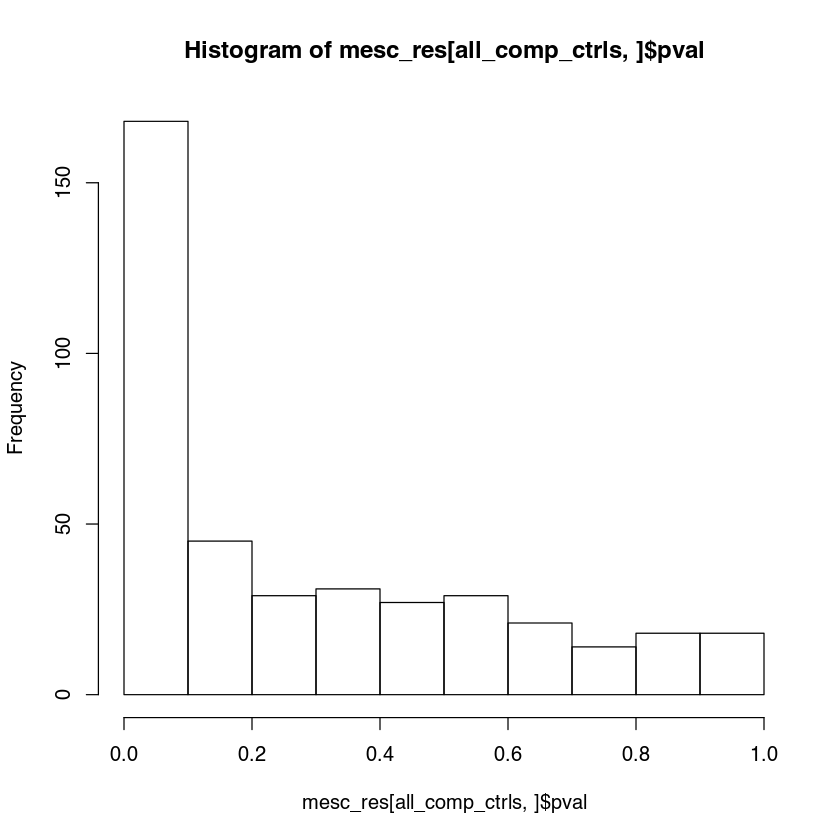

In [69]:
hist(mesc_res[all_comp_ctrls,]$pval)

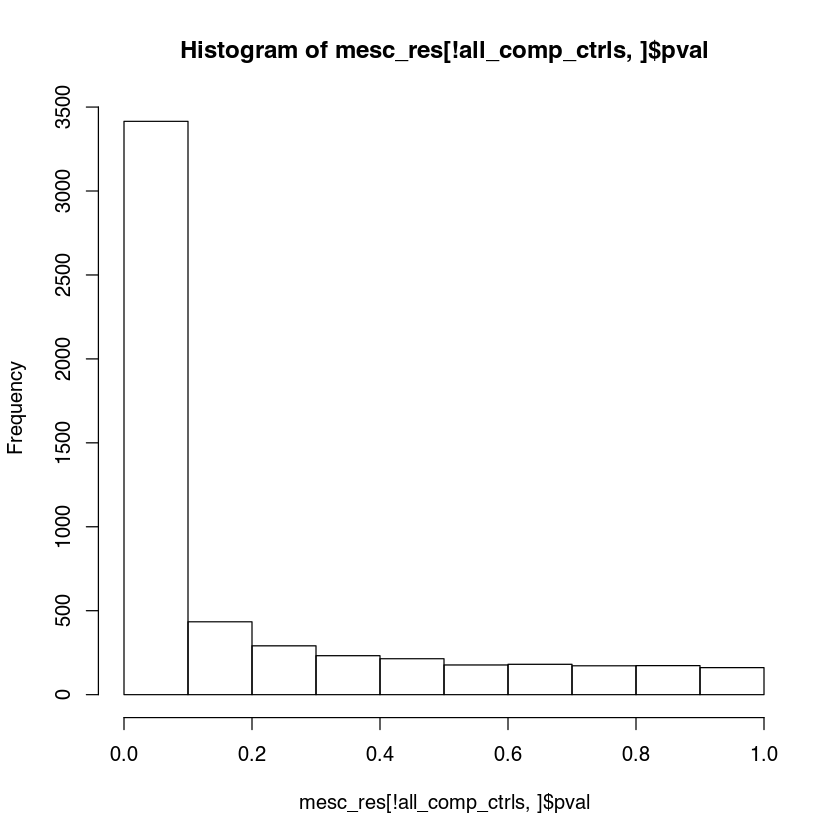

In [70]:
hist(mesc_res[!all_comp_ctrls,]$pval)

In [71]:
write.table(mesc_res, file = "../../../data/02__mpra/02__activs/mESC_cis_results.txt", sep = "\t",
            quote = FALSE)

## 7. run model to compare cells for human seq

In [72]:
# note 13 will change depending how many barcodes there are per element
human_rna_cols$depth <- rep(rna_depths, each=13)

In [73]:
# create MPRA object
obj4 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = human_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = human_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [74]:
obj4 <- setDepthFactors(obj4, dnaDepth = all_comp_dna_cols$depth, rnaDepth = human_rna_cols$depth)

In [75]:
obj4 <- analyzeComparative(obj = obj4, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-94890763.9754332
iter:3	log-likelihood:-94815739.6888083
iter:4	log-likelihood:-94780193.4641354
iter:5	log-likelihood:-94758292.5270895
iter:6	log-likelihood:-94747090.2713609
iter:7	log-likelihood:-94744210.3842476
iter:8	log-likelihood:-94747520.3688905
Fitting model...
Fitting reduced model...
Analysis Done!


In [76]:
human_trans_res <- testLrt(obj4)
head(human_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__div_lnc__m.1__div_lnc__tile1,2.414932,0.1201832167,0.262928877,1,14,5,4,-0.3331181
h.3__div_lnc__m.2__antisense__tile1,1.300051,0.2542039627,0.419608686,1,13,5,4,0.4672902
h.4__antisense_upep__m.3__protein_coding__tile1,1.529970,0.2161168871,0.380579106,1,14,5,4,0.2606727
h.5__intergenic__m.4__intergenic_upep__tile1,13.244164,0.0002734298,0.005094154,1,14,5,4,0.4399749
h.6__intergenic__m.4__intergenic_upep__tile1,3.927616,0.0474992262,0.151593275,1,14,5,4,0.2339481
h.7__div_lnc__m.5__div_lnc__tile1,4.200208,0.0404190328,0.139089025,1,14,5,4,0.2143028


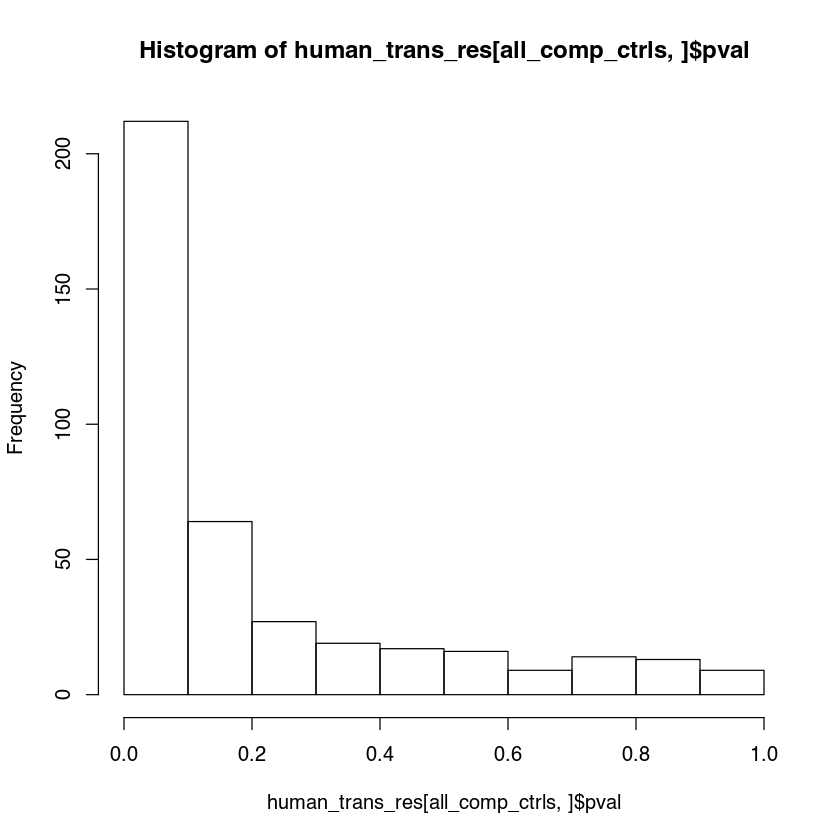

In [77]:
hist(human_trans_res[all_comp_ctrls,]$pval)

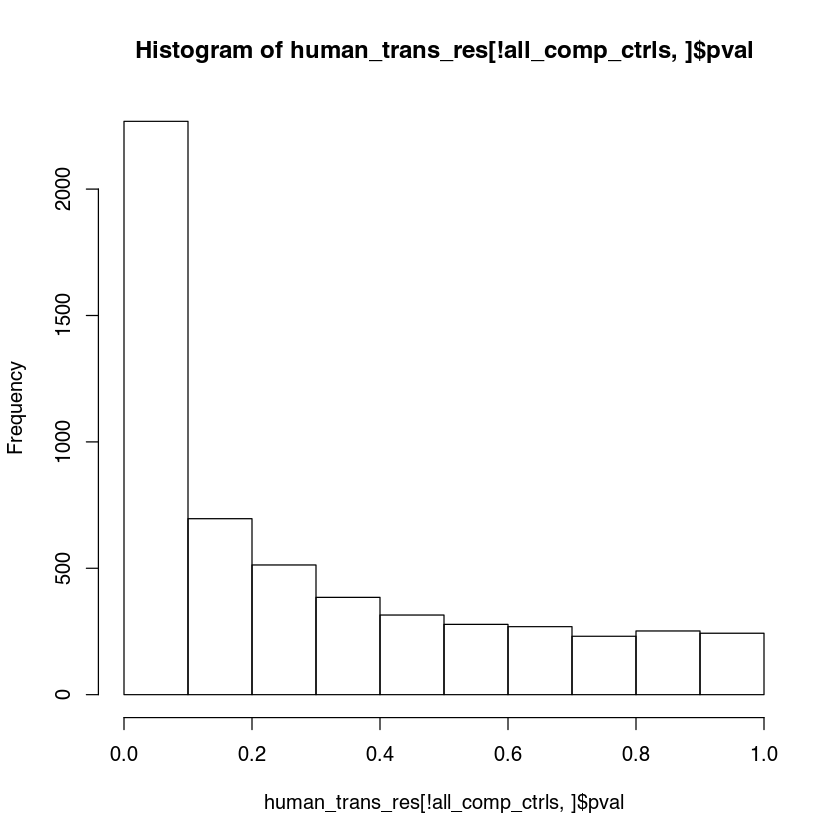

In [78]:
hist(human_trans_res[!all_comp_ctrls,]$pval)

In [79]:
write.table(human_trans_res, file = "../../../data/02__mpra/02__activs/human_trans_results.txt", sep = "\t",
            quote = FALSE)

## 8. run model to compare cells for mouse seq

In [80]:
# note 13 will change depending how many barcodes there are per element
mouse_rna_cols$depth <- rep(rna_depths, each=13)

In [81]:
# create MPRA object
obj5 <- MpraObject(dnaCounts = all_comp_dna_counts, rnaCounts = mouse_rna_counts, 
                   dnaAnnot = all_comp_dna_cols, rnaAnnot = mouse_rna_cols, controls = all_comp_ctrls,
                   BPPARAM = SnowParam(workers=16,type="SOCK"))

In [82]:
obj5 <- setDepthFactors(obj5, dnaDepth = all_comp_dna_cols$depth, rnaDepth = mouse_rna_cols$depth)

In [83]:
obj5 <- analyzeComparative(obj = obj5, 
                           dnaDesign = ~ barcode, 
                           rnaDesign = ~ condition, 
                           reducedDesign = ~ 1) 

Fitting controls-based background model...
iter:2	log-likelihood:-94818434.1504288
iter:3	log-likelihood:-94761604.4465388
iter:4	log-likelihood:-94733738.4449672
iter:5	log-likelihood:-94716410.0412832
iter:6	log-likelihood:-94707409.3034201
iter:7	log-likelihood:-94704952.1766923
iter:8	log-likelihood:-94707332.9411588
Fitting model...
Fitting reduced model...
Analysis Done!


In [84]:
mouse_trans_res <- testLrt(obj5)
head(mouse_trans_res)

Performing Likelihood Ratio Test...


,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
h.2__div_lnc__m.1__div_lnc__tile1,3.3249177,0.068237431,0.18963847,1,14,5,4,-0.32286386
h.3__div_lnc__m.2__antisense__tile1,7.1233850,0.007608492,0.04609716,1,13,5,4,0.53660989
h.4__antisense_upep__m.3__protein_coding__tile1,0.1022549,0.749140224,0.85046969,1,14,5,4,0.05881213
h.5__intergenic__m.4__intergenic_upep__tile1,1.9671052,0.160755466,0.32129125,1,14,5,4,-0.27468705
h.6__intergenic__m.4__intergenic_upep__tile1,1.6811706,0.194768981,0.36228034,1,14,5,4,-0.26750340
h.7__div_lnc__m.5__div_lnc__tile1,0.6786731,0.410043995,0.58449254,1,14,5,4,0.18335407


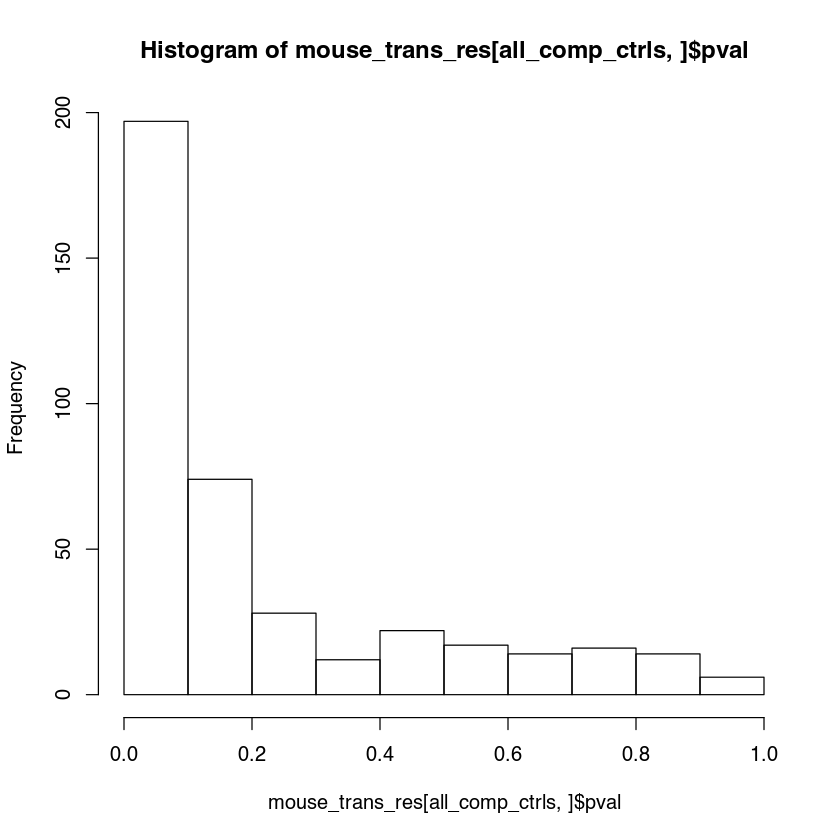

In [85]:
hist(mouse_trans_res[all_comp_ctrls,]$pval)

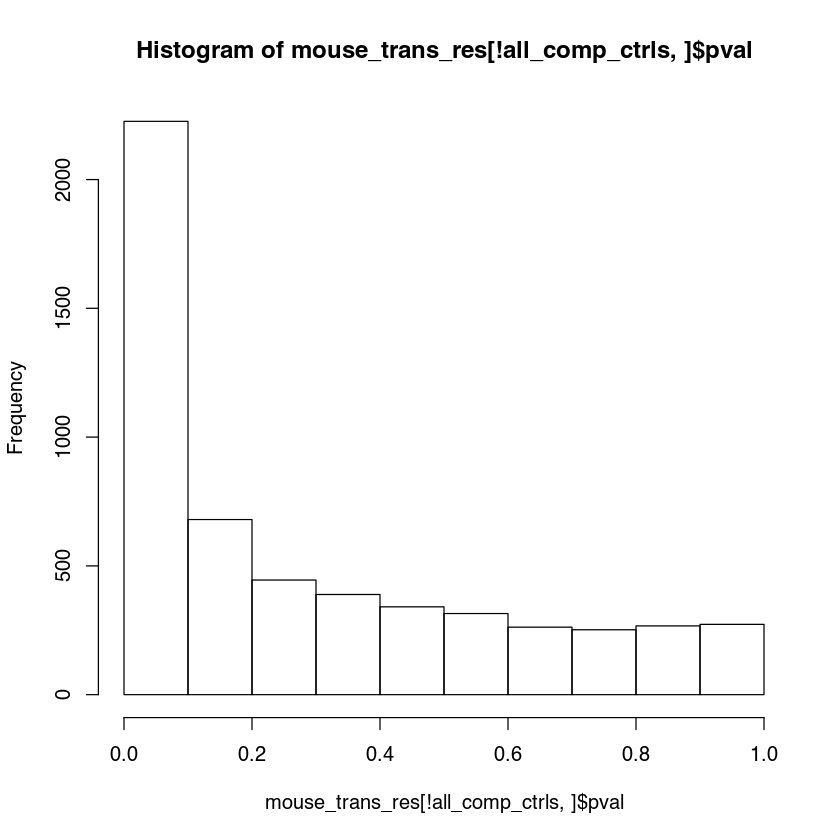

In [86]:
hist(mouse_trans_res[!all_comp_ctrls,]$pval)

In [87]:
write.table(mouse_trans_res, file = "../../../data/02__mpra/02__activs/mouse_trans_results.txt", sep = "\t",
            quote = FALSE)